In [1]:
# | label: setup
# | echo: false

import difflib as dl
import re
from pathlib import Path

import duckdb
import numpy as np
import pandas as pd
#import plotly.express as px
from ydata_profiling import ProfileReport

from IPython.display import Markdown


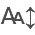

In [2]:
from itables import init_notebook_mode  # Display dataframes in a friendly manner

init_notebook_mode(all_interactive=True)

In [3]:
# | label: data_source
# | echo: false

DATA_URL = "https://hbiostat.org/data/repo/titanic3.csv"  # hopefully this is a "definitive" source

### Source data - "1999 Original" (`titanic3`)

The source data has moved a few times:

- TODO

The latest incarnation can be found here:

- https://hbiostat.org/data/
- https://hbiostat.org/data/repo/titanic
- https://hbiostat.org/data/repo/titanic3.csv

and has been replicated countless times including the Kaggle version.


Is it possible to find actual date of birth for each passanger? These data sources only have age (it seems).

These data sets were downloaded from https://www.kaggle.com/c/titanic/data

#### DuckDB setup

In [4]:
def load_data_duckdb(table_name="titanic", data_url=DATA_URL):
    load_data_sql = f"CREATE OR REPLACE TABLE {table_name} AS SELECT * FROM read_csv_auto('{data_url}')"
    con = duckdb.connect()
    con.sql(load_data_sql)
    return con

In [5]:
def load_sql_query(file_path):
    """Load the contents of a .sql file if it exists.

    Args:
    file_path (str): The path to the .sql file.

    Returns:
    str: The contents of the .sql file ready to be processed by a duckdb connection.
    """
    file = Path(file_path)
    if not file.is_file() or file.suffix != '.sql':
        raise FileNotFoundError("The file does not exist or is not a .sql file.")
    sql = file.read_text()
    Markdown(f"```{sql}```")
    return sql


In [6]:
def create_view(con, view_name, sql):
    con.sql(f"CREATE VIEW {view_name} AS {sql}")

In [7]:
con = load_data_duckdb()  # this CSV has home.dest renamed to home_dest

In [8]:
con.sql("SHOW TABLES;")

┌─────────┐
│  name   │
│ varchar │
├─────────┤
│ titanic │
└─────────┘

In [9]:
con.sql("DESCRIBE titanic;")

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ pclass      │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ survived    │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ name        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ sex         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ age         │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ sibsp       │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ parch       │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ ticket      │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ fare        │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ cabin       │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ embarked    │ VARC

In [10]:
df = con.sql("SELECT * FROM titanic").df()

In [11]:
con.sql("SELECT name FROM titanic TABLESAMPLE 10")

┌────────────────────────────────────────┐
│                  name                  │
│                varchar                 │
├────────────────────────────────────────┤
│ Oxenham, Mr. Percy Thomas              │
│ Coleridge, Mr. Reginald Charles        │
│ Beauchamp, Mr. Henry James             │
│ Coutts, Master. William Loch "William" │
│ Aks, Master. Philip Frank              │
│ Saade, Mr. Jean Nassr                  │
│ Sirayanian, Mr. Orsen                  │
│ Berriman, Mr. William John             │
│ Abelseth, Miss. Karen Marie            │
│ Boulos, Master. Akar                   │
├────────────────────────────────────────┤
│                10 rows                 │
└────────────────────────────────────────┘

In [12]:
# The primary error in the regex pattern is due to improper nesting, resulting in an unterminated subpattern.
# Fix the regex in the `extract_name_components` function and ensure the pattern handles the title correctly.

import re

def extract_name_components(full_name):
    # Updated regex pattern to account for the observed variations
    name_pattern = re.compile(
        r'(?P<surname>[\w\s\-\.\']+),\s*'
        r'(?P<title>Mr\.|Mrs\.|Miss\.|Ms\.|Dr\.|Rev\.|Mme\.|Mlle\.|Master\.|Col\.|Capt\.|Lady\.|Sir\.|Major\.|Don\.|Dona\.|the Countess\. of|Jonkheer\.)\s*'
        r'(?P<given_names>[\w\s\'.-]+)?'
        r'(\((?P<additional_info>.*)\))?'
    )
    
    match = name_pattern.match(full_name.strip())
    
    if match:
        surname = match.group('surname').strip()
        title = match.group('title').strip()
        given_names = match.group('given_names').strip() if match.group('given_names') else ''
        additional_info = match.group('additional_info').strip() if match.group('additional_info') else ''
        
        if additional_info:
            given_names = f"{given_names} ({additional_info})"
        
        return surname, title, given_names
    else:
        return None, None, None

name_components = df['name'].apply(extract_name_components)

# Ensure that we handle cases where `extract_name_components` might return None
# We filter out such cases to avoid errors during unpacking
name_components = name_components.dropna()

# Unpack the components correctly
df['Surname'], df['Title'], df['Given Names'] = zip(*name_components)

In [13]:
# The error occurs because `x` in the lambda function is a tuple, which does not have an `any` method. 
# Instead, we should check if any of the elements in the tuple are None using `any`.

df["null_name_coomp"] = name_components.apply(lambda x: any(el is None for el in x))

In [14]:
# df[df["null_name_coomp"]]["name"].tolist()

In [15]:
df

pclass  survived                                             name  \
0          1         1                    Allen, Miss. Elisabeth Walton   
1          1         1                   Allison, Master. Hudson Trevor   
2          1         0                     Allison, Miss. Helen Loraine   
3          1         0             Allison, Mr. Hudson Joshua Creighton   
4          1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)   
...      ...       ...                                              ...   
1304       3         0                             Zabour, Miss. Hileni   
1305       3         0                            Zabour, Miss. Thamine   
1306       3         0                        Zakarian, Mr. Mapriededer   
1307       3         0                              Zakarian, Mr. Ortin   
1308       3         0                               Zimmerman, Mr. Leo   

         sex    age  sibsp  parch  ticket      fare    cabin embarked  boat  \
0     female  29.00      0      0   24160  211.3375       B5        S     2   
1       male   0.92      1      2  113781  151.5500  C22 C26        S    11   
2     female   2.00      1      2  113781  151.5500  C22 C26        S  None   
3       male  30.00      1      2  113781  151.5500  C22 C26        S  None   
4     female  25.00      1      2  113781  151.5500  C22 C26        S  None   
...      ...    ...    ...    ...     ...       ...      ...      ...   ...   
1304  female  14.50      1      0    2665   14.4542     None        C  None   
1305  female    NaN      1      0    2665   14.4542     None        C  None   
1306    male  26.50      0      0    2656    7.2250     None        C  None   
1307    male  27.00      0      0    2670    7.2250     None        C  None   
1308    male  29.00      0      0  315082    7.8750     None        S  None   

       body                        home.dest    Surname    Title  \
0       NaN                     St Louis, MO      Allen    Miss.   
1       NaN  Montreal, PQ / Chesterville, ON    Allison  Master.   
2       NaN  Montreal, PQ / Chesterville, ON    Allison    Miss.   
3     135.0  Montreal, PQ / Chesterville, ON    Allison      Mr.   
4       NaN  Montreal, PQ / Chesterville, ON    Allison     Mrs.   
...     ...                              ...        ...      ...   
1304  328.0                             None     Zabour    Miss.   
1305    NaN                             None     Zabour    Miss.   
1306  304.0                             None   Zakarian      Mr.   
1307    NaN                             None   Zakarian      Mr.   
1308    NaN                             None  Zimmerman      Mr.   

                            Given Names  null_name_coomp  
0                      Elisabeth Walton            False  
1                         Hudson Trevor            False  
2                         Helen Loraine            False  
3               Hudson Joshua Creighton            False  
4     Hudson J C (Bessie Waldo Daniels)            False  
...                                 ...              ...  
1304                             Hileni            False  
1305                            Thamine            False  
1306                        Mapriededer            False  
1307                              Ortin            False  
1308                                Leo            False  

[1309 rows x 18 columns]

In [16]:
# The error occurred because "is None" is not the correct way to filter a DataFrame column for None/NaN values.
# Instead, use the .isnull() method in Pandas to check for missing values.

df["Title"].unique()

array(['Miss.', 'Master.', 'Mr.', 'Mrs.', 'Col.', 'Mme.', 'Dr.', 'Major.',
       'Capt.', 'Lady.', 'Sir.', 'Mlle.', 'Dona.', 'Jonkheer.',
       'the Countess. of', 'Don.', 'Rev.', 'Ms.'], dtype=object)

In [20]:
df['age'].describe()

age = df['age'].dropna()

q1 = age.quantile(0.25)
q3 = age.quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = age[(age < lower_bound) | (age > upper_bound)]

outliersn = len(outliers)
age_outliers_mean = outliers.mean()

age_skew = age.skew()
age_kurtosis = age.kurtosis()

{
    "Number of Outliers": outliersn,
    "Outliers Mean": age_outliers_mean,
    "Age Skewness": age_skew,
    "Age Kurtosis": age_kurtosis
}

{'Number of Outliers': 9,
 'Outliers Mean': 72.16666666666667,
 'Age Skewness': 0.40767455974362266,
 'Age Kurtosis': 0.1469476357378139}

In [27]:
df_outliers = df[df['age'].isin(outliers)]
outlier_names = df_outliers[['name', 'age', 'survived']]
outlier_names

name   age  survived
9                               Artagaveytia, Mr. Ramon  71.0         0
14                 Barkworth, Mr. Algernon Henry Wilson  80.0         1
61    Cavendish, Mrs. Tyrell William (Julia Florence...  76.0         1
81                         Crosby, Capt. Edward Gifford  70.0         0
135                           Goldschmidt, Mr. George B  71.0         0
285                                  Straus, Mr. Isidor  67.0         0
506                         Mitchell, Mr. Henry Michael  70.0         0
727                                Connors, Mr. Patrick  70.5         0
1235                                Svensson, Mr. Johan  74.0         0

In [28]:
import pandas as pd

# Load the Titanic dataset from the provided URL
url = "https://hbiostat.org/data/repo/titanic3.csv"
titanic_df = pd.read_csv(url)

# Find the oldest person to die on the Titanic
oldest_person = titanic_df[titanic_df['survived'] == 0].loc[titanic_df['age'] == titanic_df[titanic_df['survived'] == 0]['age'].max()]

oldest_person

pclass  survived                 name   sex   age  sibsp  parch  ticket  \
1235       3         0  Svensson, Mr. Johan  male  74.0      0      0  347060   

       fare cabin embarked boat  body home.dest  
1235  7.775   NaN        S  NaN   NaN       NaN

In [29]:
oldest_survivor = titanic_df[titanic_df['survived'] == 1].loc[titanic_df['age'] == titanic_df[titanic_df['survived'] == 1]['age'].max()]

oldest_survivor

pclass  survived                                  name   sex   age  sibsp  \
14       1         1  Barkworth, Mr. Algernon Henry Wilson  male  80.0      0   

    parch ticket  fare cabin embarked boat  body      home.dest  
14      0  27042  30.0   A23        S    B   NaN  Hessle, Yorks

Object `they` not found.


In [30]:
import webbrowser

url_search = "https://www.google.com/search?q=80+year+old+survived+the+sinking+of+the+Titanic"
webbrowser.open(url_search)

True

In [31]:
url_search = "https://www.google.com/search?q=oldest-survivor-titanic"
webbrowser.open(url_search)

True

In [18]:
profile = ProfileReport(df, title="Titanic Dataset", html={'style':{'full_width':True}})

In [19]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Now put the other dataset(s) age data on this plot too.

In [ ]:
# df_wikipedia = pd.read_html('https://en.m.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic', header=0)

# Not working

In [ ]:
facts_tables = pd.read_html("http://www.titanicfacts.net/titanic-passenger-list.html", header=0)

In [ ]:
facts_tables[0].info()

In [ ]:
facts_tables[1].info()

In [ ]:
facts_tables[2].info()

So the "Titanic Facts" has the data spread across 3 tables with 324 (1st class), 284 (2nd class) and 709 (3rd class) passengers (1317 total) respectively. There is age data for all 1317 passengers. Contrast this with 1309 passengers in the Kaggle dataset [which does not claim to be complete -- in fact, somewhat disappointingly, there does not appear to be a reference for the data] with only 1046 age values.

In [ ]:
facts = pd.merge(pd.merge(facts_tables[0], facts_tables[1], how="outer"), facts_tables[2], how="outer")

In [ ]:
facts.to_csv("facts.csv")

In [ ]:
facts.info()

In [ ]:
facts.head()